# Agent Supervisor Flow with LangGraph

* Start with an agent supervisor, `call_supervisor`
* Supervisor makes a decision to route to another agent or finish
* If agent, then `call_agent` to invoke the agent
* Then call supervisor with the agent output added to to agent_history `state`

Initiate LLM

In [1]:
from langchain_google_vertexai import ChatVertexAI

llm = ChatVertexAI(
                    model_name= 'gemini-1.5-flash-preview-0514',
                    temperature= 0.0,
                    top_p=0.8,
                    top_k=40,
                    verbose= True,
                    convert_system_message_to_human=False,
                    streaming = True, 
                    #set max_output_tokens to avoid random cut-offs of agent responses
                    max_output_tokens = 8000)

#### Agent Nodes 
Here we define the crew of agents available to the supervisor

Helper function to create agents:<br>
Adds default prompt, and customised agent prompt as system message<br>
Returns executor

In [2]:
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate, SystemMessagePromptTemplate

def create_tool_agent(llm: ChatVertexAI, tools: list, system_prompt: str):
    """Helper function to create agents with custom tools and system prompt
    Args:
        llm (ChatVertexAI): LLM for the agent
        tools (list): list of tools the agent will use
        system_prompt (str): text describing specific agent purpose

    Returns:
        executor (AgentExecutor): Runnable for the agent created.
    """
    
    # Each worker node will be given a name and some tools.
    
    system_prompt_template = PromptTemplate(

                template= system_prompt + """
                ONLY respond to the part of query relevant to your purpose.
                IGNORE tasks you can't complete. 
                Use the following agent history to answer your query if available: \n {agent_history} \n
                """,
                input_variables=["agent_history"],
            )

    #define system message
    system_message_prompt = SystemMessagePromptTemplate(prompt=system_prompt_template)

    prompt = ChatPromptTemplate.from_messages(
        [system_message_prompt,
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_tool_calling_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, return_intermediate_steps= True, verbose = False)
    return executor

Create Calculator Agent <br>
Create tools, define system prompt

In [3]:
from langchain.tools import tool


# setup the simple tools using LangChain tool decorator
@tool
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b


@tool
def square(a: int) -> int:
    """Calculates the square of a number."""
    a = int(a)
    return a * a

# setup the toolkit
math_toolkit = [add, multiply, square]


#define system prompt for tool calling agent
system_prompt = """ You are a mathematical assistant.
        Use your tools to answer questions. If you do not have a tool to
        answer the question, say so. """

math_agent = create_tool_agent(llm=llm, tools = math_toolkit, system_prompt = system_prompt)

Define Text Editor Agent <br>
Create tools, define system prompt

In [4]:
from langchain.tools import tool


# setup the simple tools using LangChain tool decorator
@tool
def make_upper_case(text: str) -> str:
    """ convert string to all upper case string"""
    return text.upper()


@tool
def make_lower_case(text: str) -> str:
    """ convert string to all lower case string"""
    return text.lower()

@tool
def add_smiley(text: str) -> str:
    """ add smiley face to the end of string"""
    return text + ' :)'


# setup the toolkit
text_toolkit = [make_upper_case, make_lower_case, add_smiley]


#define system prompt for tool calling agent
system_prompt = """ You are a text editor assistant.
        Use your tools to complete requests. If you do not have a tool to
       complete the request, say so. """

text_agent = create_tool_agent(llm=llm, tools = text_toolkit, system_prompt = system_prompt)

Define Communications Agent <br>
this agent will read the conversation history and communicate results to the user. 

In [5]:
from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser

#define output structure
class CommsOutput(BaseModel):
    messages: AIMessage = Field(description = 'Friendly and helpful agent response to the human query')

#create the parser for the chain based on specified output
comms_parser = JsonOutputParser(pydantic_object=CommsOutput)

system_prompt_template = PromptTemplate(

                template= """ You are a talkative and helpful assistant that summarises agent history 
                            in response to the original user query below. 
                            SUMMARISE ALL THE OUTPUTS AND TOOLS USED in agent_history.
                            The agent history is as follows: 
                        \n{agent_history}\n""",
                input_variables=["agent_history"],  )

system_message_prompt = SystemMessagePromptTemplate(prompt=system_prompt_template)

prompt = ChatPromptTemplate.from_messages(
    [
        system_message_prompt,
        MessagesPlaceholder(variable_name="messages"),
    ])

comms_agent = (prompt| llm) 

Test communications agent

In [6]:
from langchain_core.messages import HumanMessage
text_output = text_agent.invoke({"messages": [HumanMessage(content=" Hi! can you capitalise this: banana")], "agent_history": []})
comms_outputs = comms_agent.invoke({"messages": [HumanMessage(content=" Hi! how are you? can you capitalise this: banana")], "agent_history": [text_output]})
print(text_output)
print(comms_outputs)

{'messages': [HumanMessage(content=' Hi! can you capitalise this: banana')], 'agent_history': [], 'output': 'BANANA \n', 'intermediate_steps': [(ToolAgentAction(tool='make_upper_case', tool_input={'text': 'banana'}, log="\nInvoking: `make_upper_case` with `{'text': 'banana'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'function_call': {'name': 'make_upper_case', 'arguments': '{"text": "banana"}'}}, response_metadata={'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE'}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_LOW'}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE'}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NE

#### Create Supervisor Agent

define members of the crew for the supervisor

In [7]:
from enum import Enum
members = ["Calculator", "TextEditor", "Communicate"]

#create options map for the supervisor output parser.
member_options = {member:member for member in members}

#create Enum object
MemberEnum = Enum('MemberEnum', member_options)

from pydantic import BaseModel

#force Supervisor to pick from options defined above
# return a dictionary specifying the next agent to call 
#under key next.
class SupervisorOutput(BaseModel):
    #defaults to communication agent
    next: MemberEnum = MemberEnum.Communicate

In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import JsonOutputParser


system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " crew of workers:  {members}. Given the following user request, and crew responses"
    " respond with the worker to act next."
    "Each worker will perform a task and respond with their results and status. When finished with the task,"
    " route to communicate to deliver the result to user. Given the conversation and crew history below, who should act next?"
            "Select one of: {options} "
            "\n{format_instructions}\n"
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed

# Using openai function calling can make output parsing easier for us
supervisor_parser = JsonOutputParser(pydantic_object=SupervisorOutput)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_history")
       
    ]
).partial(options=str(members), members=", ".join(members), format_instructions = supervisor_parser.get_format_instructions())


supervisor_chain = (
    prompt | llm |supervisor_parser
)

Create Crew Node Invocation Function

In [9]:
from langchain_core.messages import AIMessage

# For agents in the crew 
def crew_nodes(state, crew_member, name):
    
    input = {'messages': [state['messages'][-1]], 'agent_history' : state['agent_history']}
    result = crew_member.invoke(input)

    return {"agent_history": [AIMessage(content= result["output"], additional_kwargs= {'intermediate_steps' : result['intermediate_steps']}, name=name)]}

def comms_node(state):
    input = {'messages': [state['messages'][-1]], 'agent_history' : state['agent_history']}
    result = comms_agent.invoke(input)
    return {"messages": [result]}


#### Build Graph

In [10]:
import operator
from typing import Annotated, Sequence, TypedDict
import functools
from langchain_core.messages import BaseMessage

from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str 
    
    agent_history: Annotated[Sequence[BaseMessage], operator.add]


math_node = functools.partial(crew_nodes, crew_member=math_agent, name="Calculator")

text_node = functools.partial(crew_nodes, crew_member=text_agent, name="TextEditor")




workflow = StateGraph(AgentState)

workflow.add_node("TextEditor", text_node)
workflow.add_node("Calculator", math_node)

workflow.add_node("Communicate", comms_node )

workflow.add_node("Supervisor", supervisor_chain)

#### Add Edges

In [11]:

workflow.add_edge('TextEditor', "Supervisor") # add one edge for each of the agents
workflow.add_edge('Calculator', "Supervisor") # add one edge for each of the agents

workflow.add_edge('Communicate', END) # add one edge for each of the agents


# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes

workflow.add_conditional_edges("Supervisor", lambda x: x["next"], member_options)
# Finally, add entrypoint
workflow.set_entry_point("Supervisor")

graph = workflow.compile()

#### Adding Memory

In [12]:
from langgraph.checkpoint import MemorySaver

memory = MemorySaver()

# Finally, compile the graph! 
# This compiles it into a LangChain Runnable,
graph = workflow.compile(checkpointer = memory)

### Visualise the Graph

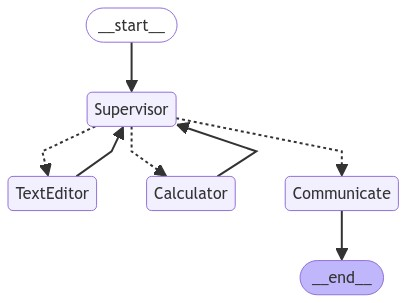

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
config = {"configurable": {"thread_id": "0"}}
from pprint import pp
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Hi! can you make the following text all upper case: 'banana' and tell me what 2*2 is?")
        ]
    }, config=config
):
    if "__end__" not in s:
        pp(s)
        print("----")

{'Supervisor': {'next': 'TextEditor'}}
----
{'TextEditor': {'agent_history': [AIMessage(content='BANANA \n', additional_kwargs={'intermediate_steps': [(ToolAgentAction(tool='make_upper_case', tool_input={'text': 'banana'}, log="\nInvoking: `make_upper_case` with `{'text': 'banana'}`\nresponded: \n4\n\n", message_log=[AIMessageChunk(content='\n4', additional_kwargs={'function_call': {'name': 'make_upper_case', 'arguments': '{"text": "banana"}'}}, response_metadata={'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE'}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_LOW'}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE'}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'seve